<a href="https://colab.research.google.com/github/usman3721/Financial-sentiment-Analysis-with-deployement/blob/main/Sentiments_Analysis_Using_Deepl_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SENTIMENT ANALYSIS USING DEEP LEARNING


In [ ]:
!pip install contractions
# !pip install --upgrade tensorflow keras



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.7 MB/s eta 0:00:00


In [ ]:

import pandas as pd
from bs4 import BeautifulSoup
from bs4 import BeautifulSoup
import re
import nltk
import tqdm
import unicodedata
import contractions
from nltk.tokenize import word_tokenize
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

nltk.download('punkt')
nltk.download('stopwords')


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Loading the Dataset
df = pd.read_csv('/content/drive/MyDrive/Mentorness Intership/Project2/Financial Sentiment Analysis/data.csv')

In [ ]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


<Axes: xlabel='Sentiment', ylabel='count'>

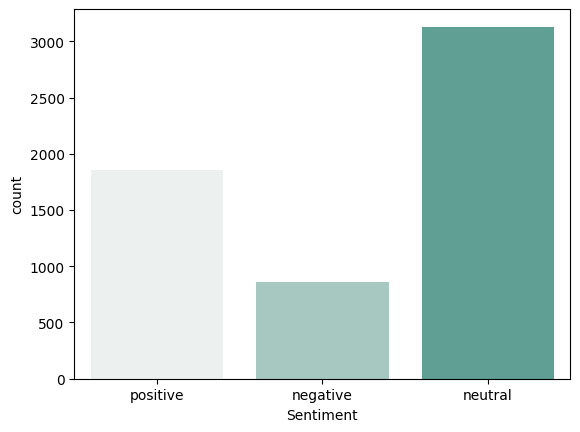

In [ ]:


import seaborn as sns
sns.countplot(data=df, x='Sentiment', palette='light:#5A9')

In [ ]:
df = df[df.Sentiment != "neutral"]


In [ ]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]

In [ ]:
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)

  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

In [ ]:
df.Sentiment.value_counts()

positive    1852
negative     860
Name: Sentiment, dtype: int64

In [ ]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
...,...,...
5832,Operating profit fell to EUR 38.1 mn from EUR ...,negative
5835,HSBC Says Unit to Book $585 Million Charge on ...,negative
5836,Daily Mail parent company in talks with potent...,positive
5837,RISING costs have forced packaging producer Hu...,negative


In [ ]:
%%time
df.Sentence = pre_process_corpus(df.Sentence)

100%|██████████| 2712/2712 [00:01<00:00, 2017.20it/s]

CPU times: user 1.27 s, sys: 65.2 ms, total: 1.33 s
Wall time: 1.36 s


In [ ]:
# Separate majority and minority classes in training data for upsampling
data_majority = df[df['Sentiment'] == "positive"]
data_minority = df[df['Sentiment'] == "negative"]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority,
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_balance = pd.concat([data_majority, data_minority_upsampled])

# Display new class counts
print("After upsampling\n",df_balance.Sentiment.value_counts(),sep = "")

majority class before upsample: (1852, 2)
minority class before upsample: (860, 2)
After upsampling
positive    1852
negative    1852
Name: Sentiment, dtype: int64


In [ ]:
# Assuming 'df' is your DataFrame
# neutral_samples = df[df['Sentiment'] == 'neutral'].sample(n=len(df[df['Sentiment'] != 'neutral']))
# df = pd.concat([neutral_samples, df[df['Sentiment'] != 'neutral']])


In [ ]:
# # Assuming 'df' is your DataFrame
# positive_samples = df[df['Sentiment'] == 'positive'].sample(n=len(df[df['Sentiment'] == 'neutral']), replace=True, random_state=42)
# negative_samples = df[df['Sentiment'] == 'negative'].sample(n=len(df[df['Sentiment'] == 'neutral']), replace=True, random_state=42)
# df = pd.concat([df[df['Sentiment'] == 'neutral'], positive_samples, negative_samples])


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df.Sentence, df.Sentiment, test_size=0.1, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((2440,), (272,), (2440,), (272,))

In [ ]:
token = Tokenizer()
token.fit_on_texts(X_train)

In [ ]:
vocab = len(token.index_word) + 1
print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Documents={}".format(token.document_count))

Vocabulary size=7459
Number of Documents=2440


In [ ]:
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

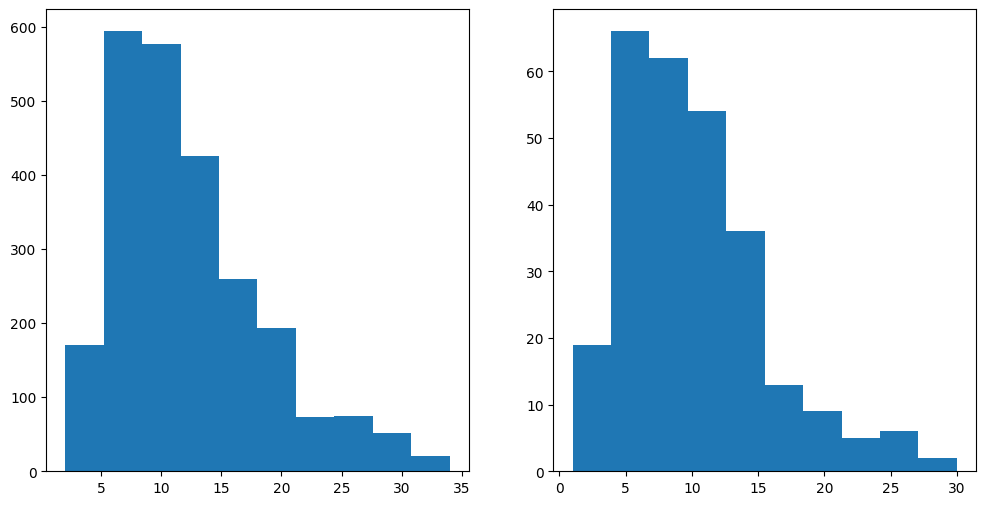

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:

#padding
MAX_SEQUENCE_LENGTH = 30
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_train.shape, X_test.shape

((2440, 30), (272, 30))

In [ ]:
le = LabelEncoder()
num_classes=2

In [ ]:

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
!pip install regularizers

ERROR: Could not find a version that satisfies the requirement regularizers (from versions: none)
ERROR: No matching distribution found for regularizers


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Dropout, Flatten

# vec_size = 300
# model = Sequential()

# # Embedding Layer
# model.add(Embedding(vocab, vec_size, input_length=MAX_SEQUENCE_LENGTH))

# # Convolutional and Pooling Layers
# model.add(Conv1D(32, 5, activation="relu"))
# model.add(MaxPooling1D(2))
# model.add(Dropout(0.4))  # Adjusted dropout rate

# # Dense Layers
# model.add(Flatten())
# model.add(Dense(16, activation="relu"))
# model.add(Dropout(0.4))

# # Output Layer
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Print the simplified model summary
# model.summary()


In [ ]:

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D,Flatten


vec_size = 300
model = Sequential()
model.add(Embedding(vocab, vec_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(32,8, activation="relu"))
model.add(MaxPooling1D(2))
# model.add(Flatten())
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 30, 300)           2238000   
                                                                 
 conv1d_8 (Conv1D)           (None, 23, 32)            76832     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 11, 32)            0         
 g1D)                                                            
                                                                 
 dense_24 (Dense)            (None, 11, 10)            330       
                                                                 
 dropout_16 (Dropout)        (None, 11, 10)            0         
                                                                 
 dense_25 (Dense)            (None, 11, 4)             44        
                                                      

In [ ]:
epochs = 100
batch_size = 15

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_cnn1d.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train,  batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/100
147/147 [==============================] - ETA: 0s - loss: 0.6395 - accuracy: 0.6721
Epoch 1: val_accuracy improved from -inf to 0.69672, saving model to ./best_model/best_model_cnn1d.h5
147/147 [==============================] - 10s 51ms/step - loss: 0.6395 - accuracy: 0.6721 - val_loss: 0.6385 - val_accuracy: 0.6967
Epoch 2/100
147/147 [==============================] - ETA: 0s - loss: 0.5297 - accuracy: 0.7177
Epoch 2: val_accuracy improved from 0.69672 to 0.79508, saving model to ./best_model/best_model_cnn1d.h5
147/147 [==============================] - 3s 18ms/step - loss: 0.5297 - accuracy: 0.7177 - val_loss: 0.4847 - val_accuracy: 0.7951
Epoch 3/100
147/147 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.8438
Epoch 3: val_accuracy improved from 0.79508 to 0.83197, saving model to ./best_model/best_model_cnn1d.h5
147/147 [==============================] - 2s 14ms/step - loss: 0.3303 - accuracy: 0.8438 - val_loss: 0.3966 - val_accuracy: 0.8320


In [ ]:
saved_model = load_model('./best_model/best_model_cnn1d.h5')
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

9/9 [==============================] - 0s 4ms/step - loss: 0.4693 - accuracy: 0.7721
Train: 97.99%, Test: 77.21%


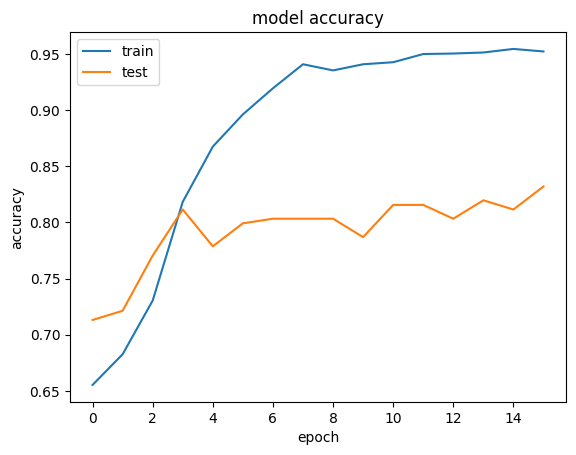

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

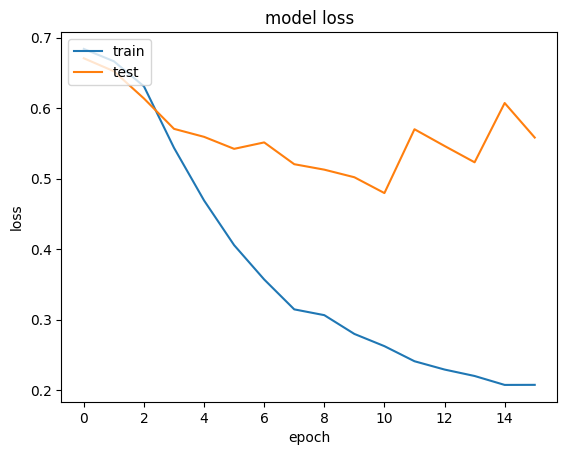

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def predictions(x):
    prediction_probs = model.predict(x)
    predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
    return predictions

In [ ]:
labels = ['positive', 'negative']
print("CNN 1D Accuracy: %.2f%%" % (accuracy_score(y_test, predictions(X_test))*100))
print("CNN 1D Precision: %.2f%%" % (precision_score(y_test, predictions(X_test), average="macro")*100))
print("CNN 1D Recall: %.2f%%" % (recall_score(y_test, predictions(X_test), average="macro")*100))
print("CNN 1D f1_score: %.2f%%" % (f1_score(y_test, predictions(X_test), average="macro")*100))
print('================================================\n')
print(classification_report(y_test, predictions(X_test)))
pd.DataFrame(confusion_matrix(y_test, predictions(X_test)), index=labels, columns=labels)

9/9 [==============================] - 0s 2ms/step
CNN 1D Accuracy: 80.51%
9/9 [==============================] - 0s 2ms/step
CNN 1D Precision: 75.79%
9/9 [==============================] - 0s 2ms/step
CNN 1D Recall: 72.65%
9/9 [==============================] - 0s 2ms/step
CNN 1D f1_score: 73.89%

9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.67      0.55      0.61        74
           1       0.84      0.90      0.87       198

    accuracy                           0.81       272
   macro avg       0.76      0.73      0.74       272
weighted avg       0.80      0.81      0.80       272

9/9 [==============================] - 0s 2ms/step


,positive,negative
positive,41,33
negative,20,178


In [ ]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

9/9 [==============================] - 0s 3ms/step
model AUC score: 72.65%


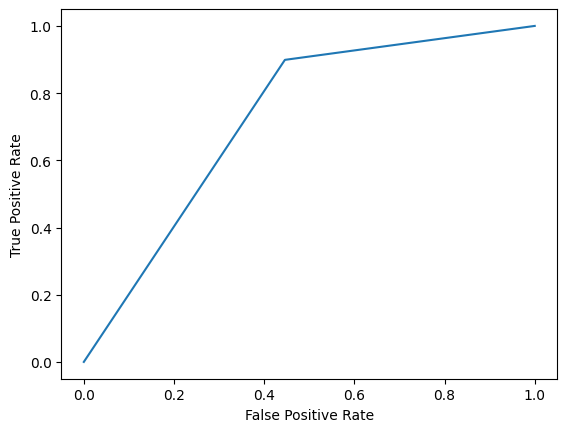

In [ ]:
plot_roc_curve(y_test, predictions(X_test))
print("model AUC score: %.2f%%" % (roc_auc_score(y_test, predictions(X_test))*100))